In [14]:
import xarray as xr
import pandas as pd
import numpy as np
from tqdm import tqdm
from pathlib import Path
import scipy
import matplotlib.pyplot as plt
from datetime import datetime, timedelta
import seaborn as sns
sns.set()


In [15]:
flux_data_path = "../PI-VAE-Climate/data_manipulation/final_day_data.parquet"
jules_data_path = Path("./half-hourly_2005-2019/")

In [16]:
start_year = 2012
end_year = 2014

In [17]:
loc_lat = 52.52161
loc_lon = 0.49861118

In [18]:
jules_data_files = list(jules_data_path.glob("*nc"))
jules_data_files = [x for x in jules_data_files if start_year <= int(x.parts[-1].split(".")[-2][:4]) <= end_year]
jules_data_files = sorted(jules_data_files, key=lambda x: (int(x.parts[-1].split(".")[-2][:4]), int(x.parts[-1].split(".")[-2][4:])))

In [19]:
flux_data = pd.read_parquet(flux_data_path)
# jules_data = []

# for data_file in tqdm(jules_data_files):
#     data_array = xr.open_dataset(data_file)
#     data_array = data_array.to_dataframe().reset_index()
#     data_array['latitude_diff_target'] = abs(data_array['latitude'] - loc_lat)
#     data_array['longitude_diff_target'] = abs(data_array['longitude'] - loc_lon)
#     min_lat = np.min(data_array['latitude_diff_target'])
#     min_long = np.min(data_array['longitude_diff_target'])
#     data_array = data_array[(data_array["latitude_diff_target"] == min_lat) & (data_array["longitude_diff_target"] == min_long)].reset_index(drop=True)
#     data_array["NEE_Jules"] = (data_array["resp_p_gb"] + data_array["resp_s_gb"] - data_array["gpp_gb"]) * 10**8
#     data_array = data_array.groupby("time").median(numeric_only=True)

#     jules_data.append(data_array)

# jules_data = pd.concat(jules_data)

In [54]:
jules_data.columns

NameError: name 'jules_data' is not defined

In [20]:
for col in flux_data.columns:
    flux_data[col] = flux_data[col].replace(-9999, np.nan)

In [21]:
def physics_nee_night(k, T, Tref=10, T0=46.02):
    e0 = k[:, 0]
    rb = k[:, 1]
    exp_term = np.exp(e0 * (1.0 / (Tref - T0) - 1.0 / (T - T0)))
    NEE = rb * exp_term
    return NEE

def physics_nee_day(k, T, Rg, Tref=10, T0=46.02):
    e0 = k[:, 0]
    rb = k[:, 1]
    alpha = k[:, 2]
    beta = k[:, 3]
    
    exp_term = np.exp(e0 * (1.0 / (Tref - T0) - 1.0 / (T - T0)))
    Reco = rb * exp_term

    GPP = (alpha * beta * Rg) / (alpha * Rg + beta)

    NEE = Reco - GPP
    return NEE

def set_season_tag(df, isnorth = True):
    if isnorth:
        df["season"] = (df['DateTime'].dt.month%12 + 3) // 3 # print(seasons)
    else:
        df["season"] = ((df['DateTime'].dt.month + 6)%12 + 3)//3
    return df, "season"

def extract_time_features(df):
    """
    Extract features from the timestamp for model training.
    
    Parameters:
    data (pd.DataFrame): DataFrame with 'Timestamp' and 'NEE' columns.
    
    Returns:
    pd.DataFrame: DataFrame with extracted features, list: features added to dataframe
    """
    df = df.copy()
    df['hour'] = df['DateTime'].dt.hour
    df['dayofweek'] = df['DateTime'].dt.dayofweek
    df['month'] = df['DateTime'].dt.month
    df['dayofyear'] = df['DateTime'].dt.dayofyear
    return df, ["hour", "dayofweek", "month", "dayofyear"]

In [45]:
flux_data["NEE_phy"] = physics_nee_night(flux_data[["E0", "rb"]].values, flux_data.Ta.values)

In [22]:
flux_data["NEE_phy"] = physics_nee_day(flux_data[["E0", "rb", "alpha", "beta"]].values, flux_data.Ta.values, flux_data.Rg.values)

In [23]:
phy_error = flux_data.NEE - flux_data.NEE_phy
mu = np.mean(phy_error)
std = np.std(phy_error)

In [15]:
noise = flux_data.NEE_phy.apply(lambda x: x + np.random.randn() * std + mu)
flux_data["NEE_phy_n"] = noise

In [16]:
flux_data, season_feat = set_season_tag(flux_data)
flux_data, time_feat = extract_time_features(flux_data)

In [13]:
flux_data[["NEE", "NEE_phy"]]

,NEE,NEE_phy
0,6.4539,6.191043
1,5.5680,6.235767
2,4.8914,6.859121
3,5.1051,7.387360
4,3.5807,6.712948
...,...,...
64480,NaN,0.694268
64481,NaN,0.674855
64482,NaN,0.652306
64483,NaN,0.637902


In [24]:
phy_error[phy_error.abs() > 100]

89      -108.674235
90      -136.586484
91      -139.745550
92      -146.237857
93      -182.325916
            ...    
61901   -134.298375
62063   -136.719440
62064   -131.199879
62065   -186.942842
62066   -185.564723
Length: 2316, dtype: float64

In [12]:
phy_error = phy_error[phy_error.abs() < 100]

Our Model Error Distribution
MEAN:  -118.24222700516722 STD:  3011.6431677970468


NormaltestResult(statistic=105718.74891078245, pvalue=0.0)

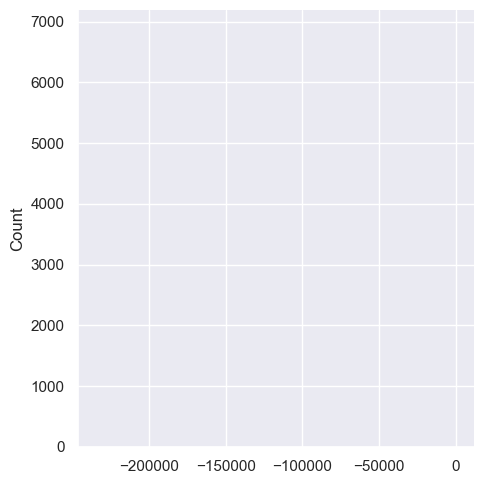

In [25]:
print("Our Model Error Distribution")
print("MEAN: ", np.mean(phy_error), "STD: ", np.std(phy_error))
sns.displot(phy_error)
scipy.stats.normaltest(phy_error, nan_policy="omit")

In [15]:
merged_data = pd.merge(jules_data, flux_data, left_on="time", right_on="DateTime")

2012-06-22


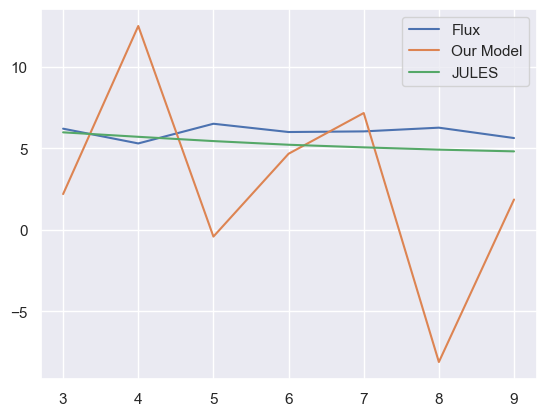

In [16]:
merged_data['time_diff'] = merged_data.DateTime.diff()

merged_data['daily_group'] = (merged_data.time_diff > pd.Timedelta(hours=2)).cumsum()

mask = (merged_data['daily_group'] == 1).values

date = merged_data.DateTime[mask].iloc[0]
date = str(date).split(' ')[0]

print(date)
plt.plot(merged_data[mask].NEE)
plt.plot(merged_data[mask].NEE_phy_n)
plt.plot(merged_data[mask].NEE_Jules)
plt.legend(["Flux", "Our Model", "JULES"])


2012-07-16 till 2012-07-22


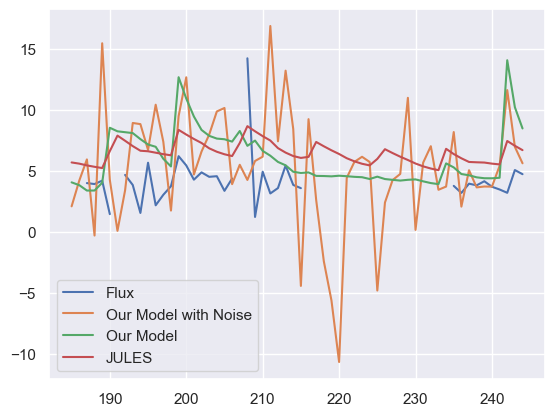

In [17]:
merged_data['week_group'] = (merged_data['dayofweek'] < merged_data['dayofweek'].shift()).cumsum()

mask = merged_data.week_group == 4

date1 = merged_data.DateTime[mask].iloc[0]
date2 = merged_data.DateTime[mask].iloc[-1]
date = str(date1).split(' ')[0] + " till " + str(date2).split(' ')[0]

print(date)
plt.plot(merged_data[mask].NEE)
plt.plot(merged_data[mask].NEE_phy_n)
plt.plot(merged_data[mask].NEE_phy)
plt.plot(merged_data[mask].NEE_Jules)
plt.legend(["Flux", "Our Model with Noise", "Our Model", "JULES"])

2012-09-01 till 2012-09-30


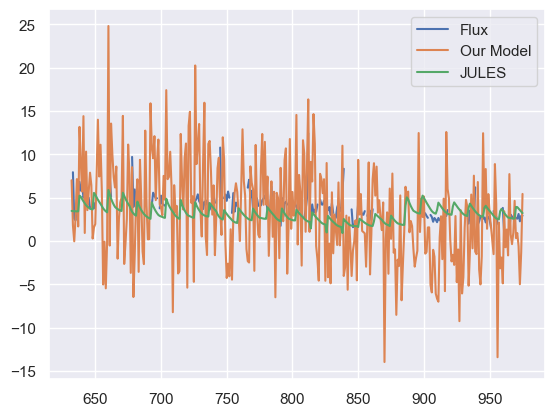

In [18]:
mask = (merged_data.DateTime.dt.year == 2012) & (merged_data.DateTime.dt.month == 9)

date1 = merged_data.DateTime[mask].iloc[0]
date2 = merged_data.DateTime[mask].iloc[-1]
date = str(date1).split(' ')[0] + " till " + str(date2).split(' ')[0]

print(date)
plt.plot(merged_data[mask].NEE)
plt.plot(merged_data[mask].NEE_phy_n)
plt.plot(merged_data[mask].NEE_Jules)
plt.legend(["Flux", "Our Model", "JULES"])

Our Model Error Distribution
MEAN:  -1.7668205799526713 STD:  5.108539782847483


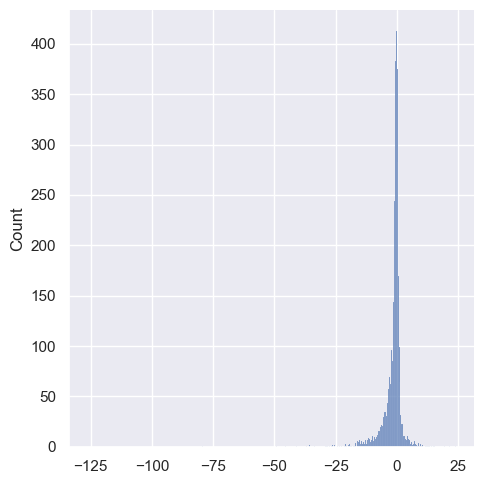

In [19]:
print("Our Model Error Distribution")
phy_error = merged_data.NEE - merged_data.NEE_phy
print("MEAN: ", np.mean(phy_error), "STD: ", np.std(phy_error))
sns.displot(phy_error)


In [27]:
list(flux_data.columns)

['DateTime',
 'NEE',
 'NEE_unc',
 'LE',
 'LE_unc',
 'H',
 'H_unc',
 'Tau',
 'Tau_unc',
 'CO2_strg',
 'LE_strg',
 'H_strg',
 'Pa',
 'Ta',
 'RH',
 'VPD',
 'Rnet',
 'Rg',
 'G1',
 'G2',
 'G3',
 'G4',
 'Tsoil1',
 'Tsoil2',
 'VWC_1',
 'VWC2',
 'Precipitation',
 'Windspeed',
 'Winddir',
 'FootprintFraction',
 'Ustar',
 'TKE',
 'Tstar',
 'L',
 'zL',
 'NEE_filled',
 'NEE_filled_sd',
 'LE_filled',
 'LE_filled_sd',
 'H_filled',
 'H_filled_sd',
 'TER',
 'GEP',
 'Day/Night',
 'Date',
 'Time (past local midnight)',
 'Julian Day',
 'Julian Century',
 'Geom Mean Long Sun (deg)',
 'Geom Mean Anom Sun (deg)',
 'Eccent Earth Orbit',
 'Sun Eq of Ctr',
 'Sun True Long (deg)',
 'Sun App Long (deg)',
 'Mean Obliq Ecliptic (deg)',
 'Obliq Corr (deg)',
 'Sun Declin (deg)',
 'var y',
 'Eq of Time (minutes)',
 'HA Sunrise (deg)',
 'Solar Noon (LST)',
 'Sunrise Time (LST)',
 'Sunset Time (LST)',
 'TimeDiff',
 'dNEE',
 'dTa',
 'dRg',
 'NEE_next',
 'window_id',
 'E0',
 'rb',
 'NEE_phy',
 'NEE_phy_n',
 'season',
 'h

In [20]:
scipy.stats.normaltest(phy_error, nan_policy="omit")

NormaltestResult(statistic=5217.799064503144, pvalue=0.0)

JULES Error Distribution
MEAN:  0.4020046628588578 STD:  2.9193796497952316


NormaltestResult(statistic=2415.367316511843, pvalue=0.0)

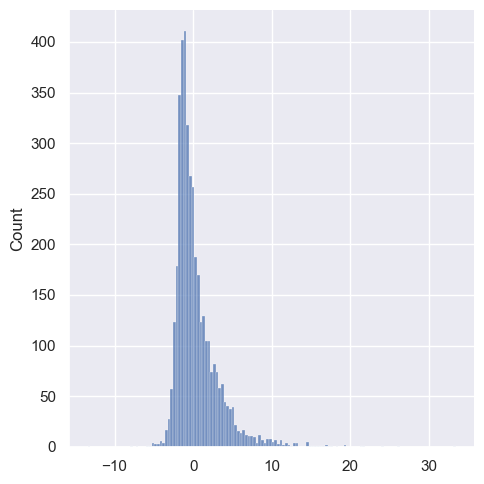

In [22]:
print("JULES Error Distribution")
jules_error = merged_data.NEE - merged_data.NEE_Jules
print("MEAN: ", np.mean(jules_error), "STD: ", np.std(jules_error))
sns.displot(jules_error)

scipy.stats.normaltest(jules_error, nan_policy="omit")

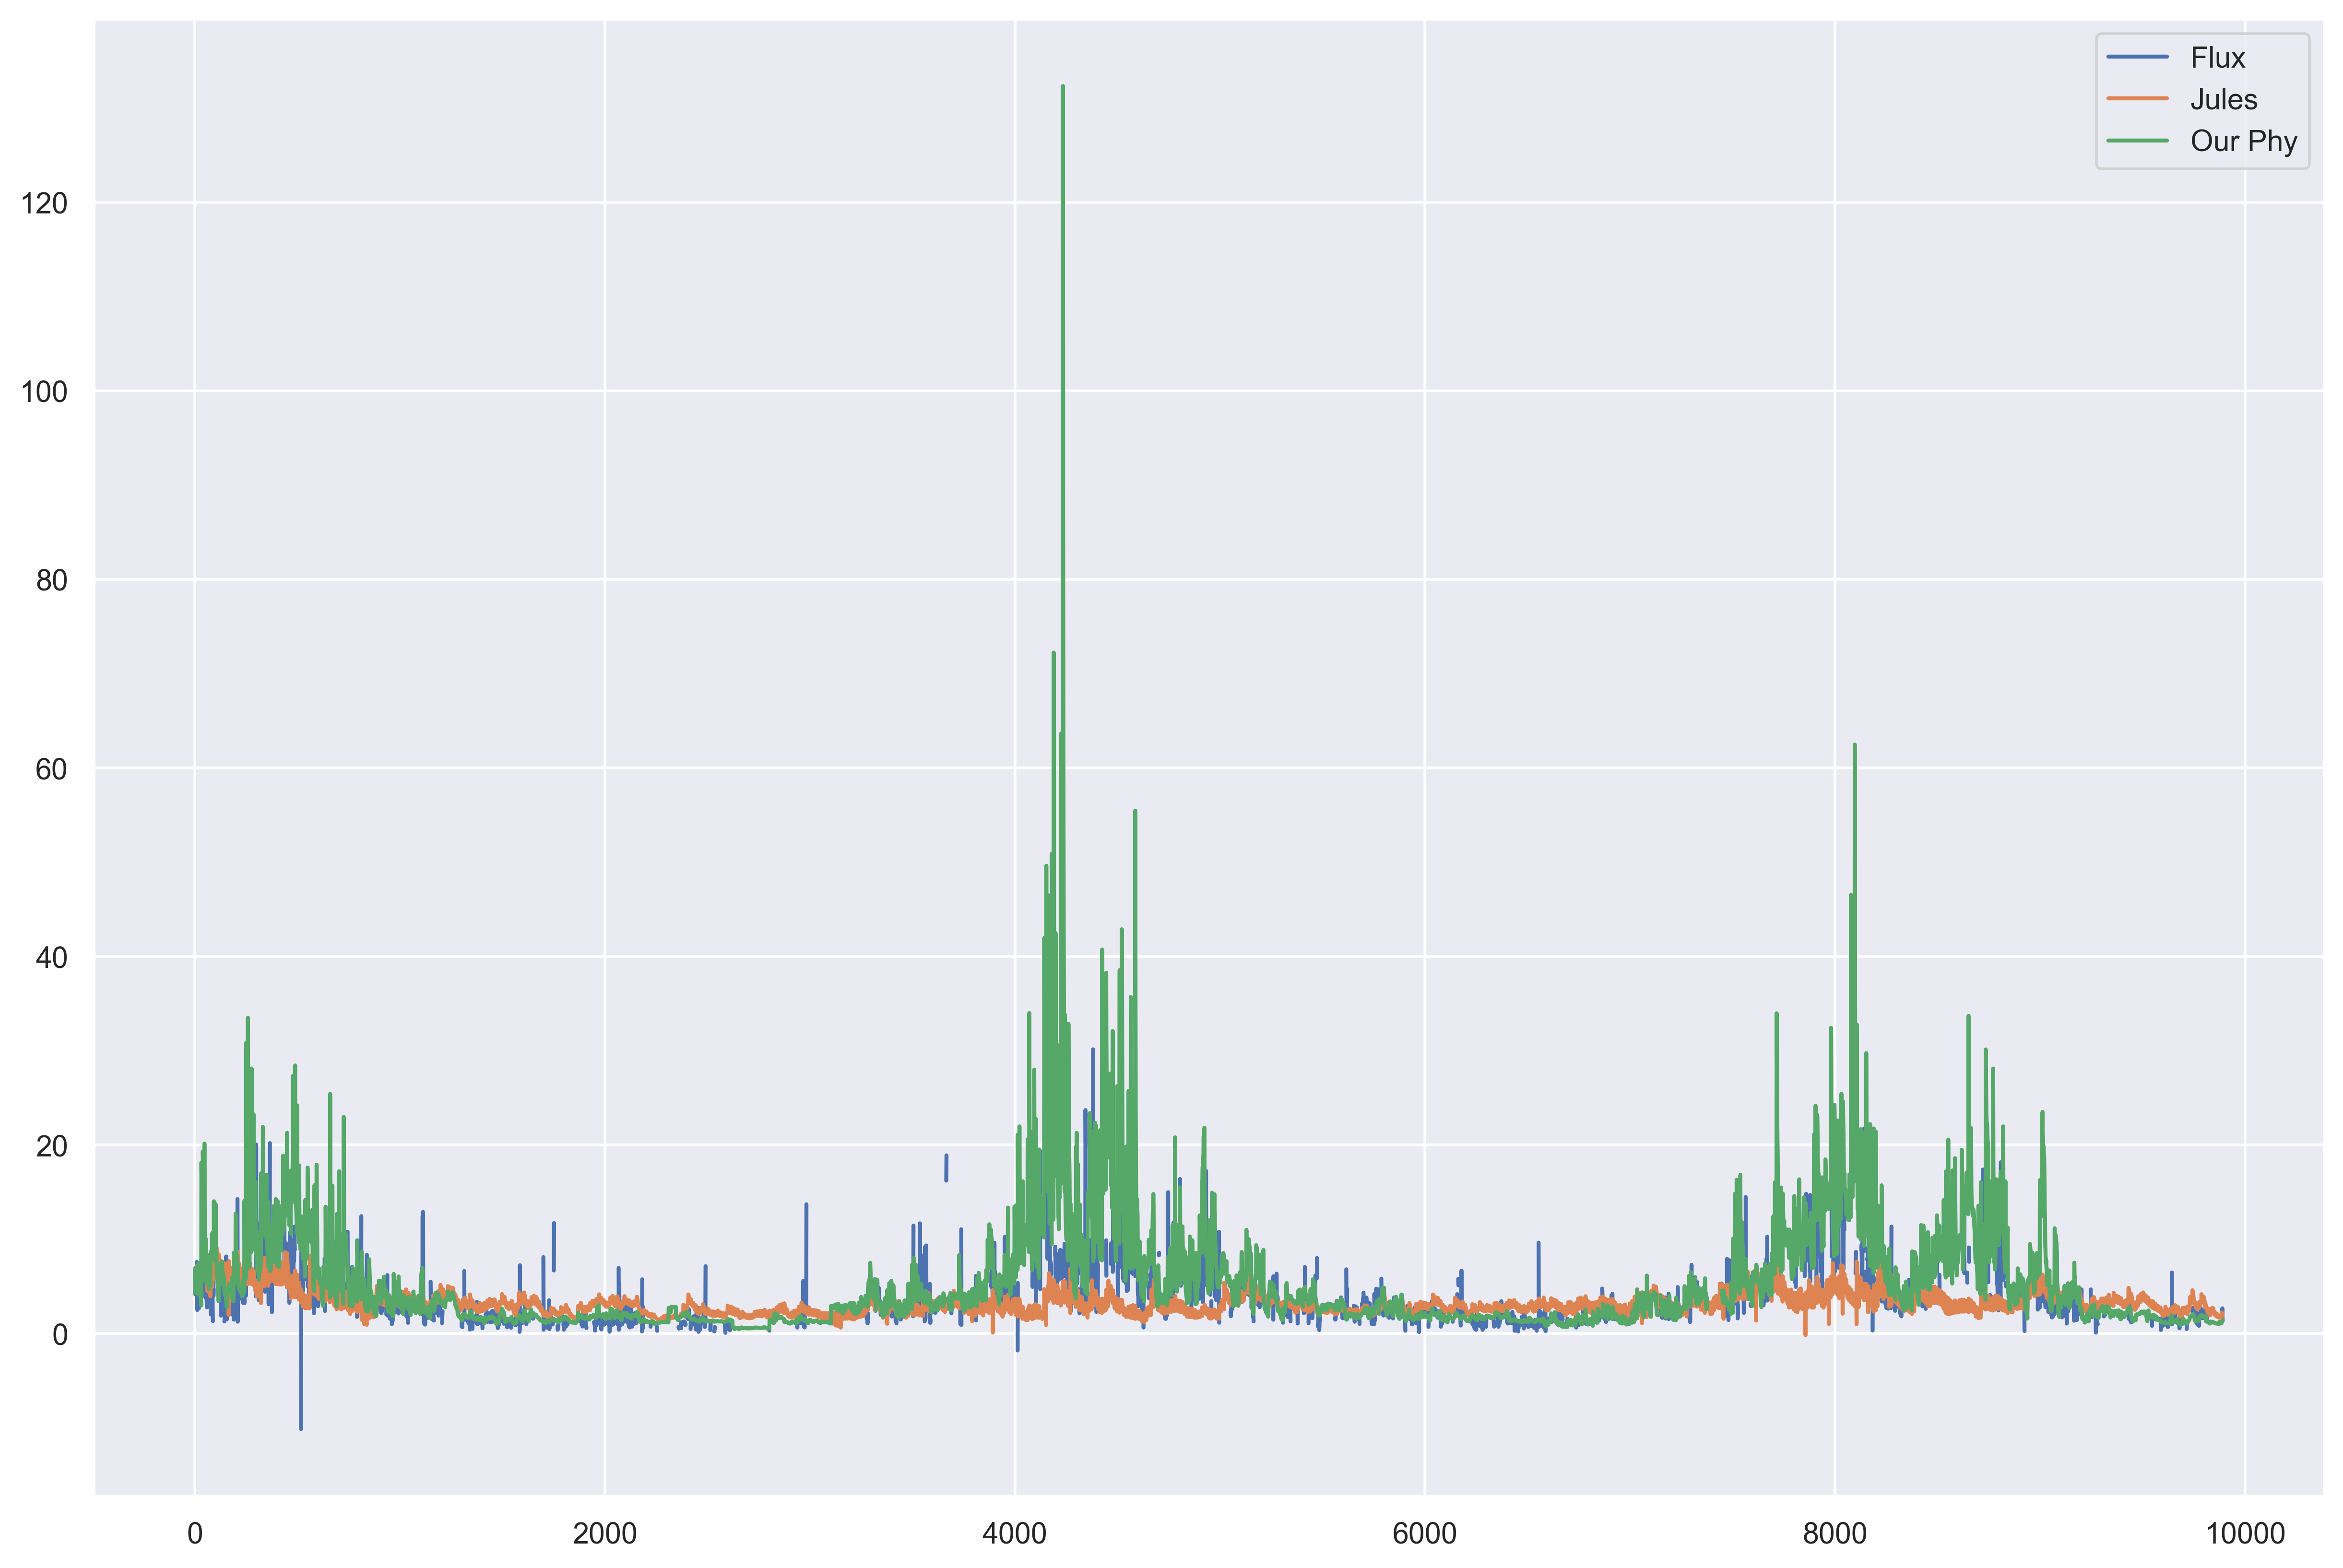

In [23]:
fig, ax = plt.subplots(figsize=(15, 10), dpi=400)
ax.plot(merged_data["NEE"])
ax.plot(merged_data["NEE_Jules"])
ax.plot(merged_data["NEE_phy"])
ax.legend(["Flux", "Jules", "Our Phy"])

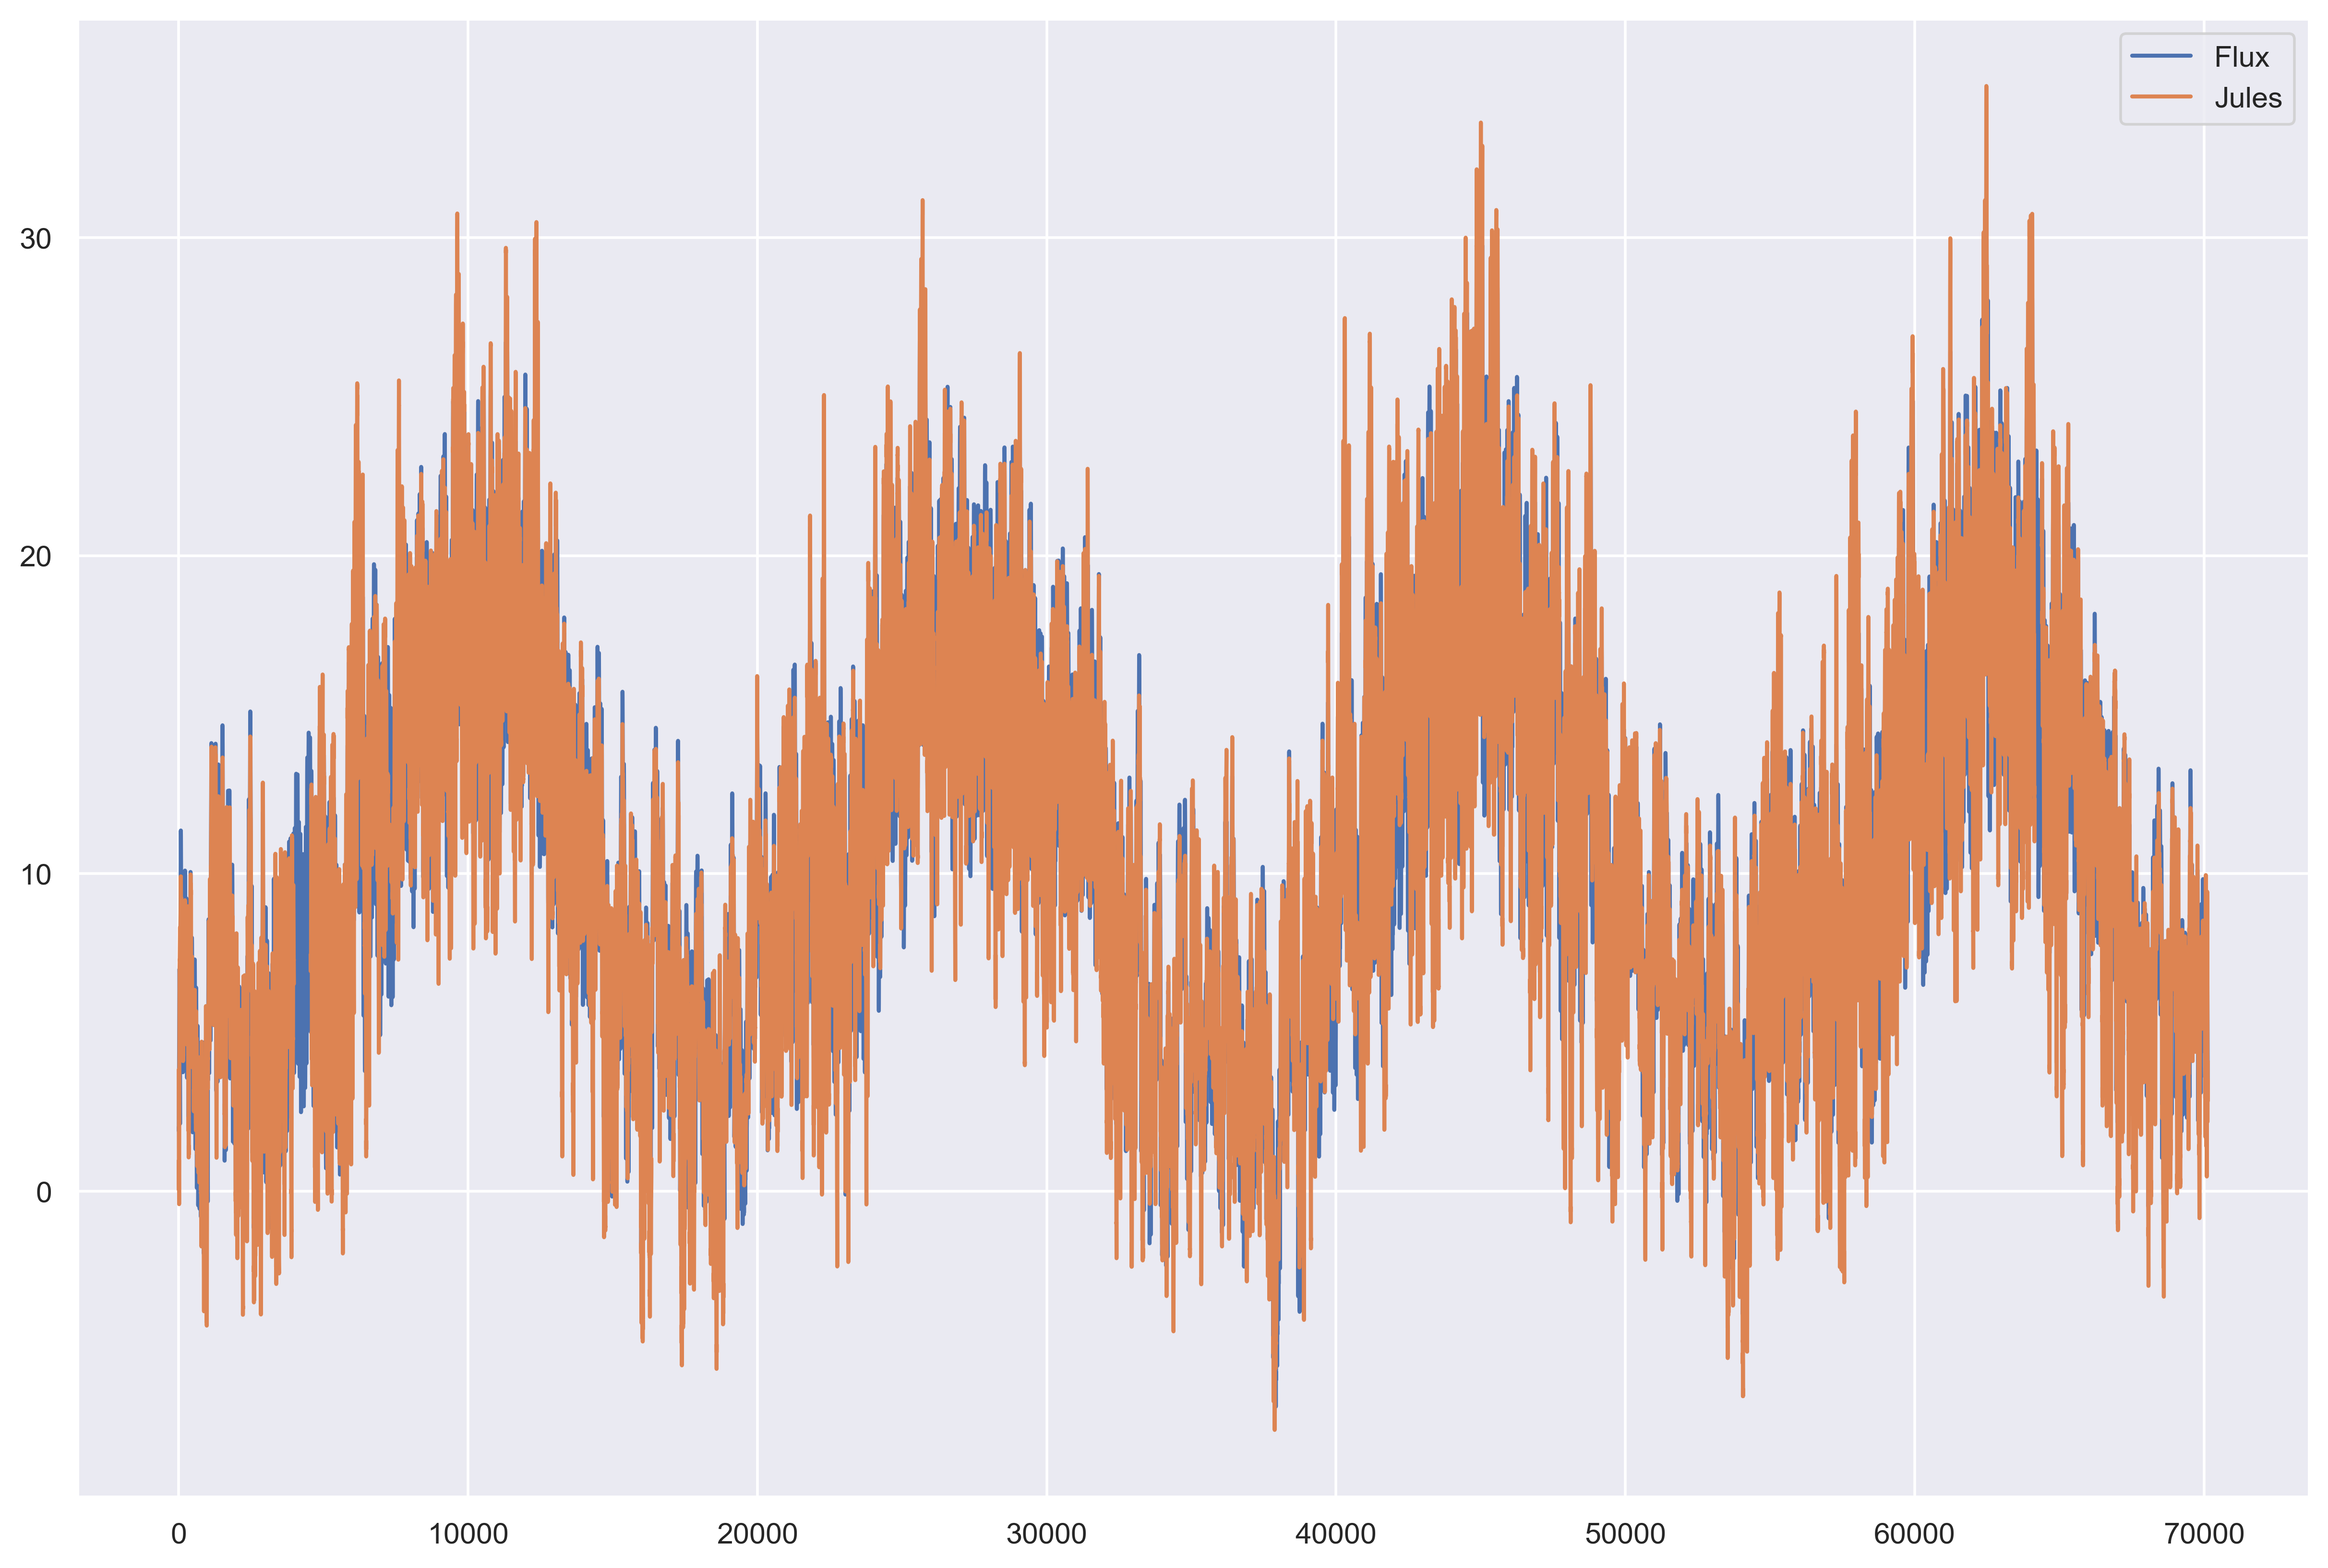

In [10]:
fig, ax = plt.subplots(figsize=(15, 10), dpi=400)

plt.plot(merged_data["t1p5m_gb"] - 273.15)
plt.plot(merged_data["Ta"])
ax.legend(["Flux", "Jules"])

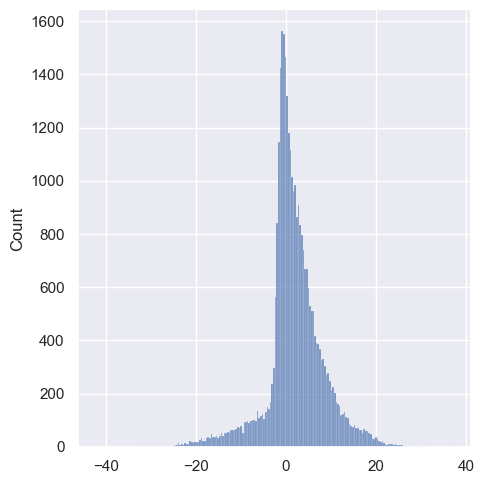

In [11]:
err = merged_data["NEE"] - merged_data["NEE_Jules"]
sns.displot(err)

In [12]:
scipy.stats.normaltest(err, nan_policy="omit")

NormaltestResult(statistic=2281.3545561613655, pvalue=0.0)

In [14]:
flux_data.columns

Index(['DateTime', 'NEE', 'NEE_unc', 'LE', 'LE_unc', 'H', 'H_unc', 'Tau',
       'Tau_unc', 'CO2_strg', 'LE_strg', 'H_strg', 'Pa', 'Ta', 'RH', 'VPD',
       'Rnet', 'Rg', 'G1', 'G2', 'G3', 'G4', 'Tsoil1', 'Tsoil2', 'VWC_1',
       'VWC2', 'Precipitation', 'Windspeed', 'Winddir', 'FootprintFraction',
       'Ustar', 'TKE', 'Tstar', 'L', 'zL', 'NEE_filled', 'NEE_filled_sd',
       'LE_filled', 'LE_filled_sd', 'H_filled', 'H_filled_sd', 'TER', 'GEP',
       'Day/Night', 'Date', 'Time (past local midnight)', 'Julian Day',
       'Julian Century', 'Geom Mean Long Sun (deg)',
       'Geom Mean Anom Sun (deg)', 'Eccent Earth Orbit', 'Sun Eq of Ctr',
       'Sun True Long (deg)', 'Sun App Long (deg)',
       'Mean Obliq Ecliptic (deg)', 'Obliq Corr (deg)', 'Sun Declin (deg)',
       'var y', 'Eq of Time (minutes)', 'HA Sunrise (deg)', 'Solar Noon (LST)',
       'Sunrise Time (LST)', 'Sunset Time (LST)'],
      dtype='object')

In [104]:
merged_data["Date"] = merged_data["DateTime"].apply(lambda x: x.date())
merged_data["Time"] = merged_data["DateTime"].apply(lambda x: x.time())

In [121]:
timestamps = [(datetime.strptime("0000", "%H%M") + timedelta(minutes=30 * i)).strftime("%H%M") for i in range(48)]

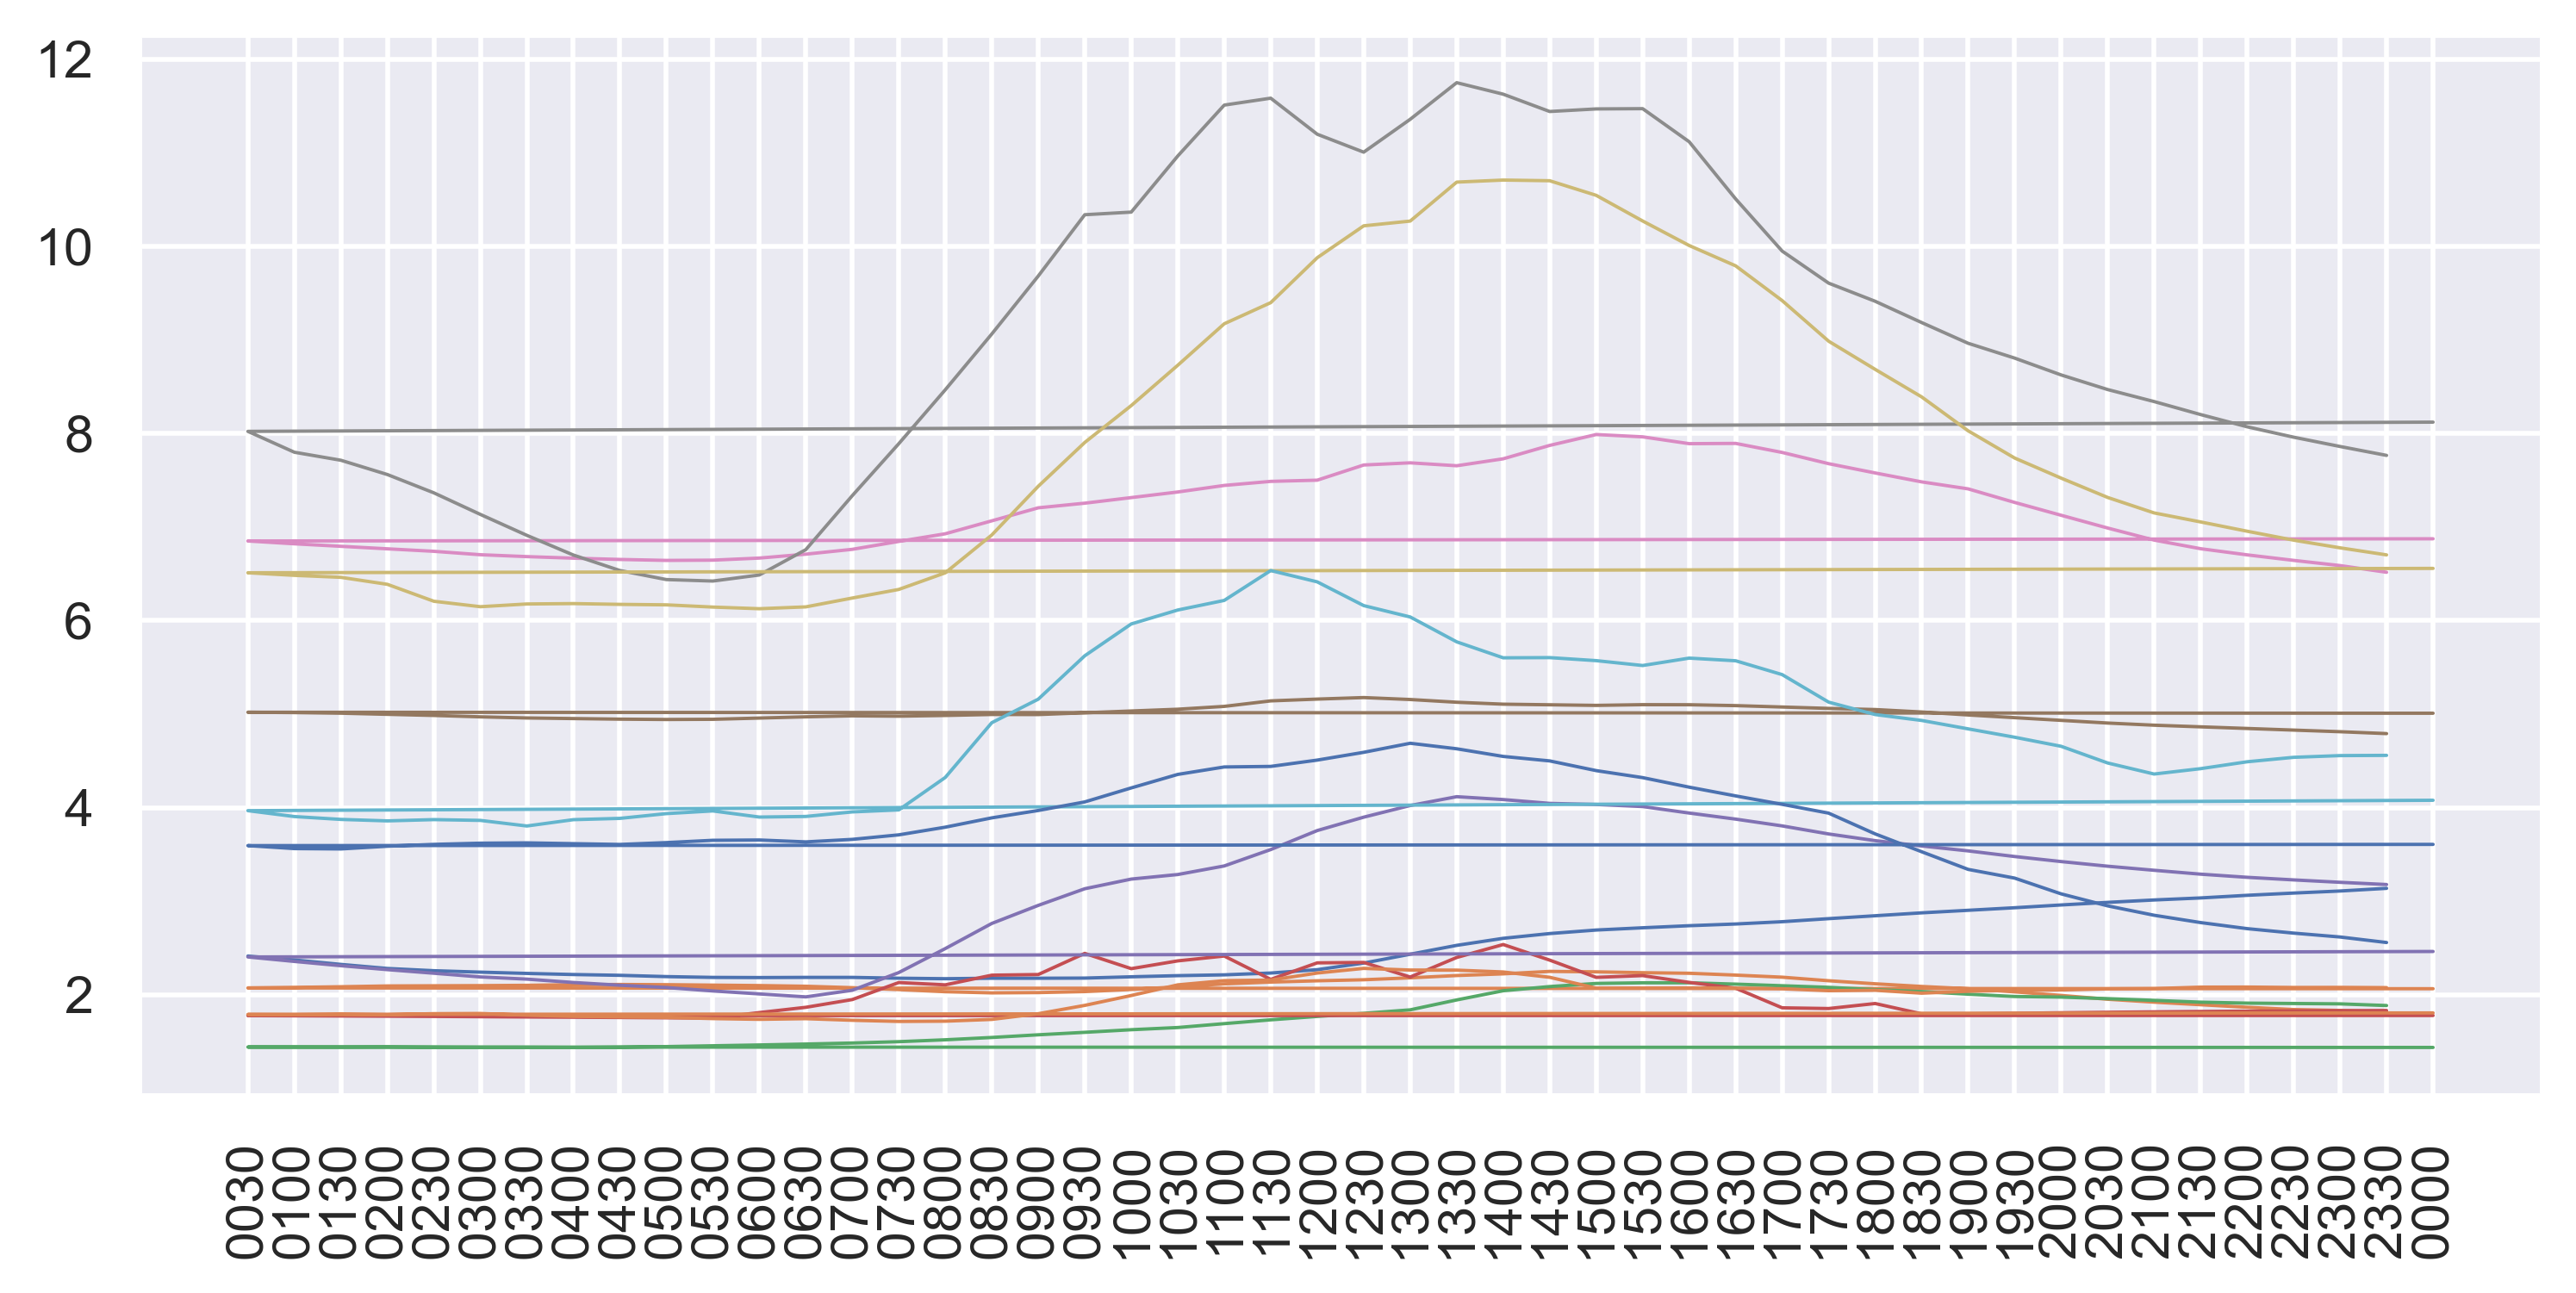

In [136]:
fig, ax = plt.subplots(figsize=(9, 4), dpi=400)

prev_month = 0
for date, indices in merged_data.groupby("Date").indices.items():
    month = date.month
    year = date.year
    if year != 2016:
        break
    if month == prev_month:
        continue
    prev_month = month
    sample_data = merged_data.loc[indices]
    ax.plot([datetime.strftime(x, "%H%M") for x in sample_data["DateTime"]], sample_data["TER"].values, linewidth=0.7)
    ax.text()

_ = plt.setp(plt.gca().xaxis.get_majorticklabels(),
         'rotation', 90)

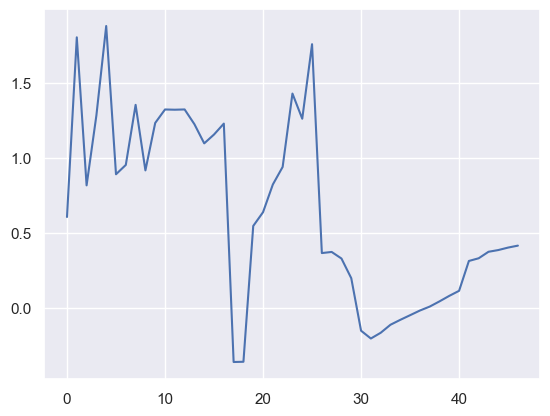

In [25]:
plt.plot(merged_data[("2016-01-01" <= merged_data["DateTime"]) & (merged_data["DateTime"]< "2016-01-02")]["GEP"])

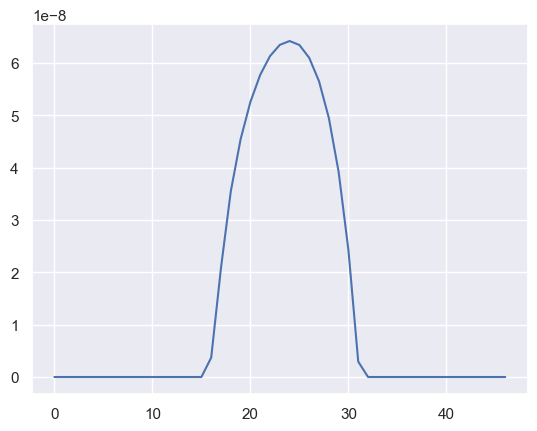

In [27]:
plt.plot(merged_data[("2016-01-01" <= merged_data["DateTime"]) & (merged_data["DateTime"]< "2016-01-02")]["gpp_gb"])